In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
import PIL
from PIL import Image
from torchvision import transforms
from torch import cuda
from tqdm.notebook import tqdm
from torchvision.transforms.functional import InterpolationMode


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
class My_train_dataset():
  def __init__(self, path, shape=256):
    self.path = path + 'train/'
    self.data = pd.read_csv(path + 'train_masks.csv')
    self.train_transfroms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
    ])


  def rle_decode(self, mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

  def __len__(self):
    return len(self.data)

  def __getitem__(self, key):
    return (self.train_transfroms(Image.open(self.path + self.data['img'][key])), self.train_transfroms(self.rle_decode(self.data['rle_mask'][key])))



In [ ]:
batch_size = 30
image_shape = 256
dataset = My_train_dataset('drive/MyDrive/data_seg/', shape=image_shape)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

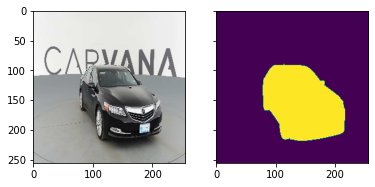

In [ ]:
i = 15
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(transforms.ToPILImage()(dataset[i][0]).convert("RGB"))
ax2.imshow(transforms.ToPILImage()(dataset[i][1]))

In [ ]:
class My_unet(nn.Module):
  def __init__(self):
    super(My_unet, self).__init__()
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2, stride=2)
    self.softmax = nn.LogSoftmax(dim=1)
    self.conv0_1 = nn.Conv2d(3, 32, 3, stride=1)
    self.conv0_2 = nn.Conv2d(32, 64, 3, stride=1)
    self.conv1_1 = nn.Conv2d(64, 64, 3, stride=1)
    self.conv1_2 = nn.Conv2d(64, 64, 3, stride=1)
    self.conv2_1 = nn.Conv2d(64, 64, 3, stride=1)
    self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1)
    self.conv3_1 = nn.Conv2d(64, 64, 1, stride=1)
    self.conv3_2 = nn.Conv2d(64, 64, 1, stride=1)
    self.conv4_1 = nn.Conv2d(128, 64, 1, stride=1)
    self.conv4_2 = nn.Conv2d(64, 64, 1, stride=1)
    self.conv5_1 = nn.Conv2d(128, 64, 1, stride=1)
    self.conv5_2 = nn.Conv2d(64, 64, 1, stride=1)
    self.conv6_1 = nn.Conv2d(64, 64, 1, stride=1)
    self.conv6_2 = nn.Conv2d(64, 64, 1, stride=1)
    self.conv7_1 = nn.Conv2d(128, 64, 1, stride=1)
    self.conv7_2 = nn.Conv2d(64, 64, 1, stride=1)
    self.conv8_1 = nn.Conv2d(64, 32, 1, stride=1)
    self.conv8_2 = nn.Conv2d(32, 2, 1, stride=1)
    self.upconv1 = nn.ConvTranspose2d(64, 64, 66, stride=1)
    self.upconv2 = nn.ConvTranspose2d(64, 64, 66, stride=1)
    self.upconv3 = nn.ConvTranspose2d(64, 64, 66, stride=1)
    self.upconv4 = nn.ConvTranspose2d(64, 64, 5, stride=1)
  
  def forward(self, x): 
    x = self.conv0_1(x) 
    x = self.relu(x)
    x = self.conv0_2(x) 
    x = self.relu(x)
    x1 = self.maxpool(x) 
    x1 = self.conv1_1(x1) 
    x1 = self.relu(x1)
    x1 = self.conv1_2(x1) 
    x1 = self.relu(x1)
    x2 = self.maxpool(x1) 
    x2 = self.conv2_1(x2) 
    x2 = self.relu(x2)
    x2 = self.conv2_2(x2) 
    x2 = self.relu(x2)

    #decoder
    x3 = self.conv3_1(x2)
    x3 = self.relu(x3)
    x3 = self.conv3_2(x3)
    x3 = self.relu(x3) 
    x3 = torch.cat((x3, x2), dim=1) 
    x3 = self.conv4_1(x3)
    x3 = self.relu(x3)
    x3 = self.conv4_2(x3)
    x3 = self.relu(x3)
    x3 = self.upconv1(x3)
    x3 = torch.cat((x3, x1), dim=1)
    x3 = self.conv5_1(x3)
    x3 = self.relu(x3)
    x3 = self.conv5_2(x3)
    x3 = self.relu(x3)
    x3 = self.upconv2(x3)
    x3 = self.conv6_1(x3)
    x3 = self.relu(x3)
    x3 = self.conv6_2(x3)
    x3 = self.relu(x3)
    x3 = self.upconv3(x3)
    x3 = torch.cat((x3, x), dim=1)
    x3 = self.conv7_1(x3)
    x3 = self.relu(x3)
    x3 = self.conv7_2(x3)
    x3 = self.relu(x3)
    x3 = self.upconv4(x3)
    x3 = self.conv8_1(x3)
    x3 = self.conv8_2(x3)
    x3 = self.softmax(x3)
    return x3

In [ ]:
model = My_unet()
model_path = 'drive/MyDrive/seg_model0_1'
model.load_state_dict(torch.load(model_path))
for param in model.parameters():
    param.requires_grad = True

device = 'cuda' if cuda.is_available() else 'cpu'
model.to(device)
device

'cuda'

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs, batch_size=batch_size, image_shape=image_shape):
    loss = nn.NLLLoss()
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Iterate over data.
        for inputs, labels in tqdm(train_dataloader):
          inputs = inputs.to(device)   #requires_grad = True
          labels = (labels * 300).to('cpu').reshape(-1, image_shape, image_shape).type(torch.LongTensor)

          optimizer.zero_grad()
          # forward and backward
          preds = model(inputs)
          loss_value = loss(preds.to('cpu'), labels)

          loss_value.backward()
          optimizer.step()
        torch.save(model.state_dict(), 'drive/MyDrive/seg_model2')

    return model   
    
    

NameError: ignored

In [ ]:
loss1 = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=5.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)

train_model(model, loss1, optimizer, scheduler, 10)

Epoch 0/9:


In [ ]:
torch.save(model.state_dict(), model_path)

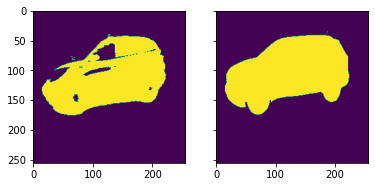

In [ ]:
# for input, target in train_dataloader:
#  break

# model.to(device)
# pred = torch.argmax(model(input.to(device)), dim=1)
# target = ((target * 300).type(torch.LongTensor).numpy())

i = 19
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(transforms.ToPILImage()(pred[i].type(torch.FloatTensor)))
ax2.imshow(target[i][0])